In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Iceberg&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Iceberg; color:#ff1155; font-size:35px;'>
    %s</h1>"""%str))

Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/gan/dcgan-cats-and-dogs.ipynb)


In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from torchvision import transforms,utils,models
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [5]:
@register_line_magic
def display_examples(data):
    letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=letters[labels[i].item()])
            ax.imshow((images[i]).reshape(img_size,img_size,3))
        break

In [6]:
dhtml('Data')

In [7]:
img_size=64
fpath='../input/classification-of-handwritten-letters/'
f='LetterColorImages2.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')
x=timage.resize(x,[img_size,img_size])
x=x.numpy().reshape(-1,3,img_size,img_size)
x=x/255
print(x.mean(),x.std())
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids][:46*128],y[shuffle_ids][:46*128]
random_seed=23; batch_size=128
train=TData(x,y)
dataloaders={'train':tdl(dataset=train,shuffle=True, 
                         batch_size=batch_size)}

['backgrounds', 'images', 'labels']
0.5649501 0.13516982


Image dimensions: torch.Size([128, 3, 64, 64])
Label dimensions: torch.Size([128])


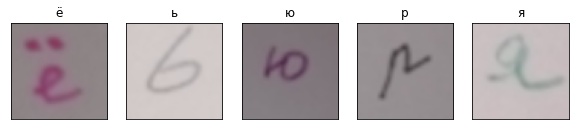

In [8]:
%display_examples train

In [9]:
dhtml('DCGAN')

In [10]:
def weights_init(module):
    classname=module.__class__.__name__
    if classname.find('Conv')!=-1:
        tnn.init.normal_(module.weight.data,0.,.02)
    elif classname.find('BatchNorm')!=-1:
        tnn.init.normal_(module.weight.data,1.,.02)
        tnn.init.constant_(module.bias.data,0)
def convt(x,y,k,s,p):
    return tnn.Sequential(
        tnn.ConvTranspose2d(
            x,y,kernel_size=k,stride=s,\
            padding=p,bias=False),\
        tnn.BatchNorm2d(y),
        tnn.ReLU(True))
def conv(x,y,k,s,p,b):
    return tnn.Sequential(
        tnn.Conv2d(x,y,kernel_size=k,
                   stride=s,padding=p,
                   bias=b),
        tnn.BatchNorm2d(y),
        tnn.LeakyReLU(.2,inplace=True))

In [11]:
class DCGAN(tnn.Module):
    def __init__(self):
        super(DCGAN,self).__init__()
        self.generator=tnn.Sequential(
            convt(latent_dim,gmaps_num*8,4,1,0),
            convt(gmaps_num*8,gmaps_num*4,4,2,1),
            convt(gmaps_num*4,gmaps_num*2,4,2,1),
            convt(gmaps_num*2,gmaps_num,4,2,1),
            tnn.ConvTranspose2d(
                gmaps_num,3,
                kernel_size=4,stride=2,
                padding=1,bias=False),
            tnn.Tanh())        
        self.discriminator=tnn.Sequential(
            conv(3,dmaps_num,4,2,1,True),
            conv(dmaps_num,dmaps_num*2,4,2,1,False),           
            conv(dmaps_num*2,dmaps_num*4,4,2,1,False),
            conv(dmaps_num*4,dmaps_num*8,4,2,1,False),
            tnn.Conv2d(
                dmaps_num*8,1,kernel_size=4,
                stride=1,padding=0),
            tnn.Sigmoid())          
    def generator_forward(self,z):
        img=self.generator(z)
        return img 
    def discriminator_forward(self,img):
        pred=model.discriminator(img)
        return pred

In [12]:
random_seed=(123); latent_dim=100
gmaps_num=64; dmaps_num=64
glearning_rate=.0018
dlearning_rate=.001
grid_num=64
torch.manual_seed(random_seed)
loss_function=tnn.BCELoss()
real_label=1; fake_label=0
fixed_noise=torch\
.randn(grid_num,latent_dim,1,1,device=dev)
model=DCGAN(); model=model.to(dev)
model.apply(weights_init)
print(model)
goptim=torch.optim.Adam(
    model.generator.parameters(),
    betas=(.5,.999),lr=glearning_rate)
doptim=torch.optim.Adam(
    model.discriminator.parameters(),
    betas=(.5,.999),lr=dlearning_rate)

DCGAN(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

In [13]:
dhtml('Training')

In [14]:
epochs=150
dcosts,gcosts=[],[]
images_from_noise=[]
info='Epoch: %03d/%03d | Batch: %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
for epoch in range(epochs):
    model=model.train()
    for batch_ids,(features,targets) in enumerate(dataloaders['train']):
        doptim.zero_grad()      
        real_images=features.to(dev)
        num_real=real_images.size(0)
        real_label_vec=torch.full((num_real,),real_label,device=dev)
        discr_pred_real=model.discriminator_forward(real_images).view(-1)
        real_loss=loss_function(discr_pred_real,real_label_vec)

        random_vec=torch.randn(batch_size,latent_dim,1,1,device=dev)
        fake_images=model.generator_forward(random_vec)
        fake_label_vec=torch.full((num_real,),fake_label,device=dev)
        discr_pred_fake=model.discriminator_forward(fake_images.detach()).view(-1)
        fake_loss=loss_function(discr_pred_fake,fake_label_vec)
        discr_loss=.5*(real_loss+fake_loss)
        discr_loss.backward()
        doptim.step()        

        goptim.zero_grad()                
        discr_pred_fake=model.discriminator_forward(fake_images).view(-1)
        gener_loss=loss_function(discr_pred_fake,real_label_vec)
        gener_loss.backward()
        goptim.step()

        dcosts.append(discr_loss.item())
        gcosts.append(gener_loss.item())
        if not batch_ids%30:
            print(info%(epoch+1,epochs,batch_ids,
                        len(dataloaders['train']),gener_loss,discr_loss))
    with torch.no_grad():
        if ((discr_loss.item()>.7 and \
            discr_loss.item()<1.2 and \
            gener_loss.item()<discr_loss.item()) or not epoch%50):
            fake_images=model\
            .generator_forward(fixed_noise).detach().cpu()
            images_from_noise.append(
                utils.make_grid(fake_images,padding=2,
                                normalize=True))

/opt/conda/conda-bld/pytorch_1591914880026/work/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


Epoch: 001/150 | Batch: 000/046 | Gen/Dis Loss: 9.1371/1.0120
Epoch: 001/150 | Batch: 030/046 | Gen/Dis Loss: 23.0748/0.9779
Epoch: 002/150 | Batch: 000/046 | Gen/Dis Loss: 7.6628/0.2438
Epoch: 002/150 | Batch: 030/046 | Gen/Dis Loss: 2.3537/0.5338
Epoch: 003/150 | Batch: 000/046 | Gen/Dis Loss: 1.7856/1.0904
Epoch: 003/150 | Batch: 030/046 | Gen/Dis Loss: 1.6558/0.9501
Epoch: 004/150 | Batch: 000/046 | Gen/Dis Loss: 1.2048/0.8519
Epoch: 004/150 | Batch: 030/046 | Gen/Dis Loss: 1.0401/0.7848
Epoch: 005/150 | Batch: 000/046 | Gen/Dis Loss: 0.9220/0.7827
Epoch: 005/150 | Batch: 030/046 | Gen/Dis Loss: 1.7242/0.7453
Epoch: 006/150 | Batch: 000/046 | Gen/Dis Loss: 1.3272/0.7390
Epoch: 006/150 | Batch: 030/046 | Gen/Dis Loss: 1.5192/0.6904
Epoch: 007/150 | Batch: 000/046 | Gen/Dis Loss: 2.0290/0.6309
Epoch: 007/150 | Batch: 030/046 | Gen/Dis Loss: 1.2262/0.7313
Epoch: 008/150 | Batch: 000/046 | Gen/Dis Loss: 1.1911/0.6776
Epoch: 008/150 | Batch: 030/046 | Gen/Dis Loss: 2.0421/0.8286
Epoch: 

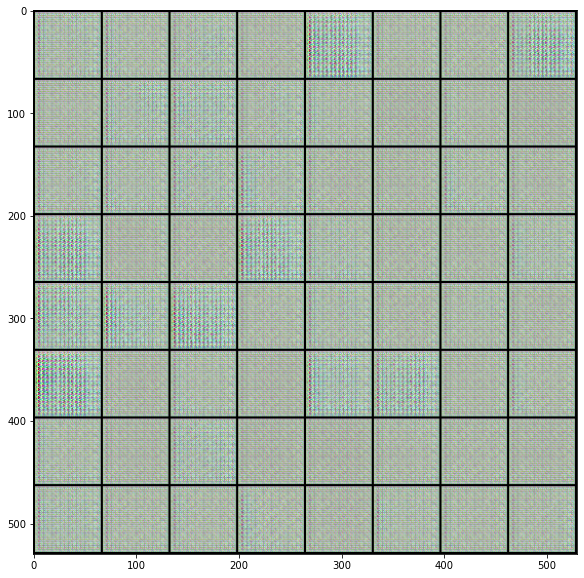

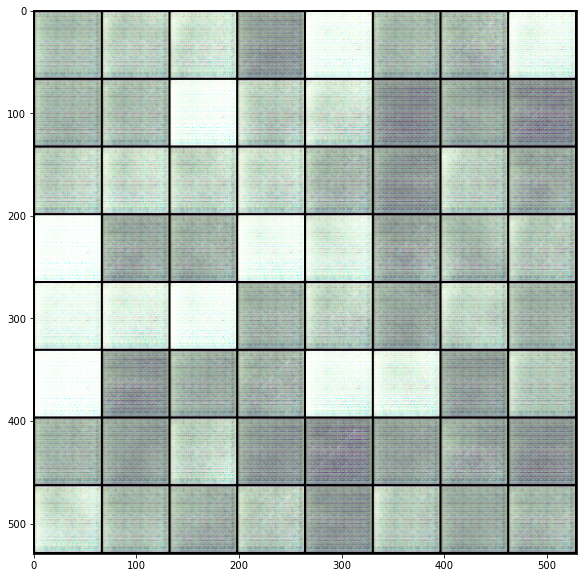

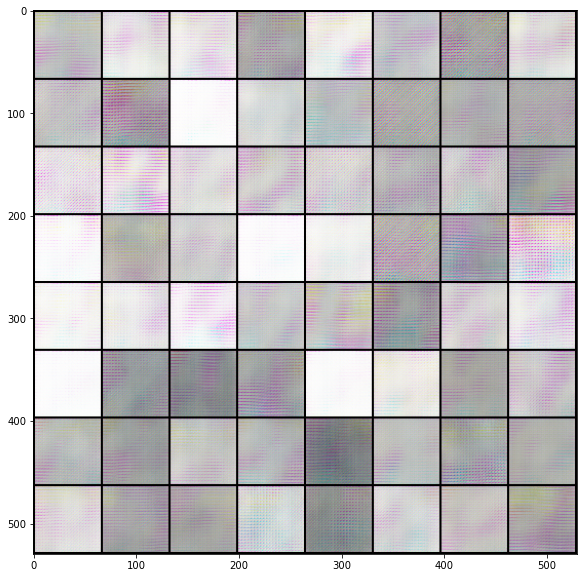

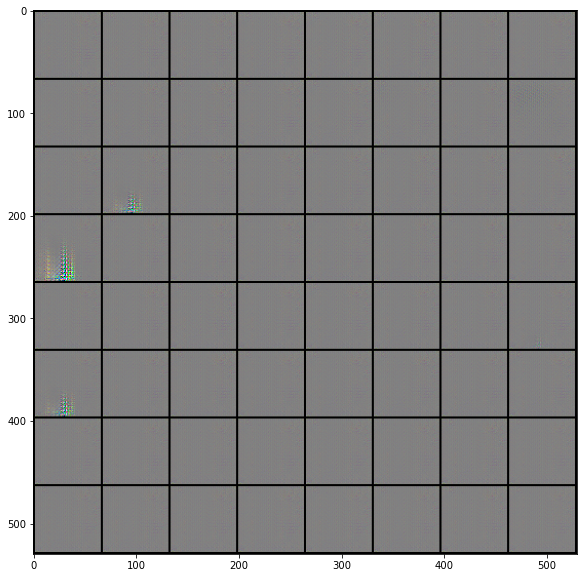

In [15]:
for i in range(len(images_from_noise)):
    pl.figure(figsize=(10,10))
    pl.imshow(np.transpose(images_from_noise[i],
                           (1,2,0)))
pl.show()